In [1]:
import numpy as np
import matplotlib.pylab as plt
from numpy.fft import fft, ifft
#import seaborn as sns
import matplotlib as mpl

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True  # for using Times New Roman fonts
plt.rc('text.latex', preamble=r'\usepackage{amsmath,dsfont}')  #to import latex package
#mpl.style.use('default')  #for 'seaborn' style or 'default'

In [2]:
#define Np range for each Seri
Np1=np.arange(0.1,1.1,0.1)
Np2=np.arange(0.01,0.1,0.01)
Np3=np.arange(0.001,0.01,0.001)
Np4=np.arange(0.0001,0.001,0.0001)
Np5=np.arange(0.00001,0.0001,0.00001)

two=np.append(Np5,Np4)
three=np.append(two,Np3)
four=np.append(three,Np2)
Np=np.append(four,Np1)

In [4]:
# Functin for loading data 
def load_data(data_name_without_Seri_number):  # for example: name='Eper6Weight15.txt'
    #Seri1 0.1<Np<=1
    n_1 = 'Seri1' + data_name_without_Seri_number
    D_1=np.loadtxt(n_1)
    D_1=np.delete(D_1,0,axis=1)

    #Seri2 0.01<Np<0.1
    n_2 = 'Seri2' + data_name_without_Seri_number
    D_2=np.loadtxt(n_2)
    D_2=np.delete(D_2,0,axis=1)
    D_2=np.delete(D_2,9,axis=0)

    #Seri3 0.001<Np<0.01
    n_3 = 'Seri3' + data_name_without_Seri_number
    D_3=np.loadtxt(n_3)
    D_3=np.delete(D_3,0,axis=1)

    #Seri4 0.0001<Np<0.001
    n_4 = 'Seri4' + data_name_without_Seri_number
    D_4=np.loadtxt(n_4)
    D_4=np.delete(D_4,0,axis=1)

    #Seri5 0.00001<Np<0.0001
    n_5 = 'Seri5' + data_name_without_Seri_number
    D_5=np.loadtxt(n_5)
    D_5=np.delete(D_5,0,axis=1)

    #final matrix to send for fft (MatI)
    p1=np.concatenate( ( np.delete(D_5,0,1),np.delete(D_4,0,1) ), axis=0)
    p2=np.concatenate( ( p1,np.delete(D_3,0,1) ), axis=0)
    p3=np.concatenate( ( p2,np.delete(D_2,0,1) ), axis=0)
    Mat=np.concatenate( ( p3,np.delete(D_1,0,1) ), axis=0)

    return(Mat)

In [5]:
# Function to calculate fft of matrices
def fft_mat(Mat):
    lag = 1000
    fftMat = []
    for i in np.arange(0,len(Mat)):
        sig=Mat[i,:]
        t=np.arange(0,len(sig))
        L=len(t[lag:])
        Fs = 1  #sampling frequency
        Y=fft(sig[lag:])
        P2 = np.abs(Y/L)
        P1 = P2[0:int(L/2)+1]
        end=len(P1)-1
        P1[1:end] = 2*P1[1:end]
        x=np.arange(0,(int(L/2)+1))
        f = Fs*x/L
        fftMat.append(P1)
    fftMat=np.rot90(fftMat)
    fftMat=np.flipud(fftMat)
    return(fftMat)

In [6]:
# Loading data 
def make_output_node(raw_name,end_row):  # example raw_name: N2000K200D4We1Wi11Ne10
    # active Excitatory neurons
    name = 'Enode' + raw_name + '.txt'  # raw_name becomes: EnodeN2000K200D4We1Wi11Ne10.txt
    MatNE=load_data(name)

    # active Inhibitory neurons
    name = 'Inode' + raw_name + '.txt'  # raw_name becomes: InodeN2000K200D4We1Wi11Ne10.txt
    MatNI=load_data(name)

    # making total active neurons matrix to send for fft
    MatN = MatNE + MatNI

    if end_row==0:
        return(MatN)

    # make fft matrix 
    else:
        fftMatN = fft_mat(MatN)
        fftMatN = fftMatN[:end_row]
    return(fftMatN)

In [7]:
# Function for finding start and end points of the activity cycles
# Input: Rho
# Output: startpoints &  endpoints

def StartAndEndPoints(Rho, precision):
    #precision=1-0.95*max(Rho)  #default = 0.05
    t=np.arange(0,len(Rho))
    tmax=max(t)
    threshold=min(Rho)
    flag=False
    i=0
    startlocs=[]
    endlocs=[]
    while i<(tmax-10):
        if ( Rho[i]-threshold <= precision ):
            i=i+1
            continue
        first=i
        if (Rho[i-1] < Rho[i]):
            first=first-1
            if i==0:
                first=0
        startlocs.append(first)
        flag=True
        while(flag and i<tmax-1):
            i=i+1
            if ( Rho[i]-threshold <= precision ):
                flag=False
        endlocs.append(i)
        i=i+1;
        
    return(startlocs,endlocs)

In [8]:
# Function for calculating burst width of a timeseri
# Input: Rho , tmax
# Output: An array including the width of the burst at each time --> y

def BurstWidth(Rho,precision):
    tmax=len(Rho)
    y=np.zeros(len(Rho))
    startlocs , endlocs = StartAndEndPoints(Rho,precision)
    startlocs.append(tmax)
    endlocs.append(tmax)
    if startlocs==[]:
        startlocs.append(0)
    if endlocs==[]:
        endlocs.append(0)
    imax=len(endlocs)-1
    i=0
    smean=9 # mean value of a silence interval
    a=startlocs[0]
    while (i<imax):
        if startlocs[i+1]-endlocs[i] < smean:
            i=i+1
            continue
        else:
            b=endlocs[i]
            c=b-a
            for j in np.arange(a,b):
                y[j] = c
            a=startlocs[i+1]
            i=i+1
    if (a<10):
        if all(v < 0.01 for v in Rho):
            y=np.zeros(len(Rho))
        else:    
            y=np.ones(len(y))
            y[0], y[len(y)-1] = 0, 0
    else:
        ymax=max(y)
        if ymax!=0:
            y=y/ymax
    return(np.array(y))

In [10]:
# Function for calculating Shanon entropy of burst width
# Input: y (The array of burst width)
# Output: hB; the shanon entropy of the bursts for the input --> a not normalized number

def BurstShanon(y):
    y_round=np.round(y, decimals=2)
    l=list(y_round)
    hB=0
    distsB=np.zeros(101)
    for i in np.arange(101):
        distsB[i] = (l.count(i/100))/len(l)
        if (distsB[i]!=0):
            hB = hB - distsB[i] * np.log2(distsB[i])
    return(hB)


In [11]:
# Making the matrix of data
end_row=0

Mat10=make_output_node('N2000K200D4We1Wi11Ne10',end_row)
Mat20=make_output_node('N2000K200D4We1Wi25Ne20',end_row)
Mat30=make_output_node('N2000K200D4We1Wi43Ne30',end_row)
Mat40=make_output_node('N2000K200D4We1Wi67Ne40',end_row)
Mat50=make_output_node('N2000K200D4We1Wi1Ne50',end_row)
Mat60=make_output_node('N2000K200D4We1Wi15Ne60',end_row)
Mat70=make_output_node('N2000K200D4We1Wi233Ne70',end_row)
Mat80=make_output_node('N2000K200D4We1Wi4Ne80',end_row)
Mat90=make_output_node('N2000K200D4We1Wi9Ne90',end_row)

In [22]:
#Making the fft matrix of data
end_row=3000

d10=make_output_node('N2000K200D4We1Wi11Ne10',end_row)
d20=make_output_node('N2000K200D4We1Wi25Ne20',end_row)
d30=make_output_node('N2000K200D4We1Wi43Ne30',end_row)
d40=make_output_node('N2000K200D4We1Wi67Ne40',end_row)
d50=make_output_node('N2000K200D4We1Wi1Ne50',4000)
d60=make_output_node('N2000K200D4We1Wi15Ne60',end_row)
d70=make_output_node('N2000K200D4We1Wi233Ne70',end_row)
d80=make_output_node('N2000K200D4We1Wi4Ne80',end_row)
d90=make_output_node('N2000K200D4We1Wi9Ne90',end_row)

In [13]:
# Making information curves for cases E=50 to E=90
precision=0.005   

# For E:10 to E:40
hB10=np.zeros(46)
hB20=np.zeros(46)
hB30=np.zeros(46)
hB40=np.zeros(46)

# For E:50
hB50=[]
for i in np.arange(len(Mat50)):
    y=BurstWidth(Mat50[i,:],precision)
    hB50.append(BurstShanon(y))

# For E:60
hB60=[]
for i in np.arange(len(Mat60)):
    y=BurstWidth(Mat60[i,:],precision)
    hB60.append(BurstShanon(y))

# For E:70
hB70=[]
for i in np.arange(len(Mat70)):
    y=BurstWidth(Mat70[i,:],precision)
    hB70.append(BurstShanon(y))

# For E:80
hB80=[]
for i in np.arange(len(Mat80)):
    y=BurstWidth(Mat80[i,:],precision)
    hB80.append(BurstShanon(y))

# For E:90
hB90=[]
for i in np.arange(len(Mat90)):
    y=BurstWidth(Mat90[i,:],precision)
    hB90.append(BurstShanon(y))

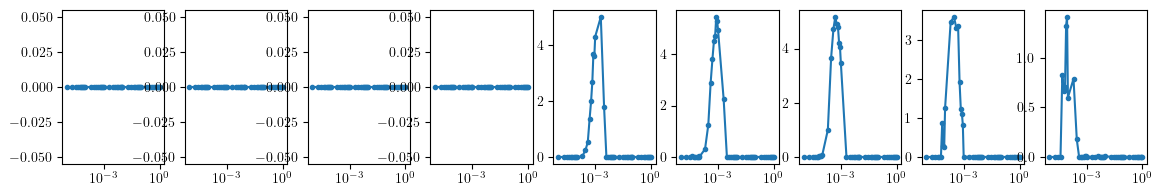

In [14]:
# Plotting information curves

plt.figure(figsize=(14,2))

for j in np.arange(9):
    plt.subplot(1,9,j+1)
    action = 'hB = hB'+str((j+1)*10)
    exec(action)
    plt.plot(Np, hB,'-o', ms=3, lw=1.5, label='Ne='+str((j+1)*10))
    plt.xscale('log')
    #plt.legend()

In [15]:
# Obtaining the area under information curves
# Using the trapezoidal rule with NumPy's trapz function since we have discrete data points

area_under_entropy_curve_log=[]
area_under_entropy_curve_real=[]

area = np.trapz(hB10, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB10, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB20, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB20, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB30, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB30, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB40, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB40, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB50, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB50, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB60, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB60, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB70, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB70, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB80, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB80, np.log10(Np))
area_under_entropy_curve_log.append(area)

area = np.trapz(hB90, Np)
area_under_entropy_curve_real.append(area)
area = np.trapz(hB90, np.log10(Np))
area_under_entropy_curve_log.append(area)

Text(0.5, 1.0, 'Log scale')

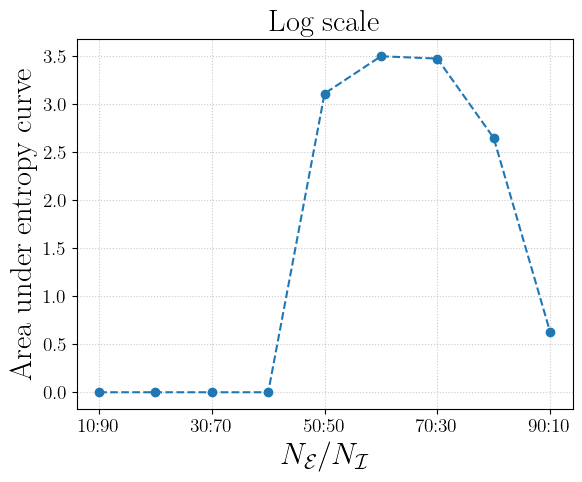

In [17]:
# Plotting the area under information curves
ff=22
plt.figure()
plt.plot(area_under_entropy_curve_log, '--o', ms=6, lw=1.5)
plt.xticks([0,2,4,6,8], labels=['10:90', '30:70', '50:50', '70:30', '90:10'], fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.ylabel('Area under entropy curve', fontsize=ff)
plt.xlabel(r'$N_{\mathcal{E}}/N_{\mathcal{I}}$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.4)
plt.title('Log scale', fontsize=ff)

In [26]:
# Calculation of the width of information curves
def width_of_curve(hB):
    counter=0
    for i in np.arange(len(hB)):
        if hB[i] >= 0.05:
            counter = counter+1
    print('width = ', counter)

# Run the function for each information curve to obtain width of curves
# For example obtaining width of curve of case E:80
width_of_curve(hB80)

width =  12


In [31]:
# Calculation of the start point of information curves (Sensitivity)
def start_of_curve(hB):
    counter=0
    flag=False
    while (not flag and counter<46):
        if hB[counter] >= 0.05:
            print('first non-zero data = ', counter)
            flag=True
        else:
            counter = counter+1

# Run the function for each information curve to obtain Sensitivity of curves
# For example obtaining width of curve of case E:80
start_of_curve(hB80)

first non-zero data =  6


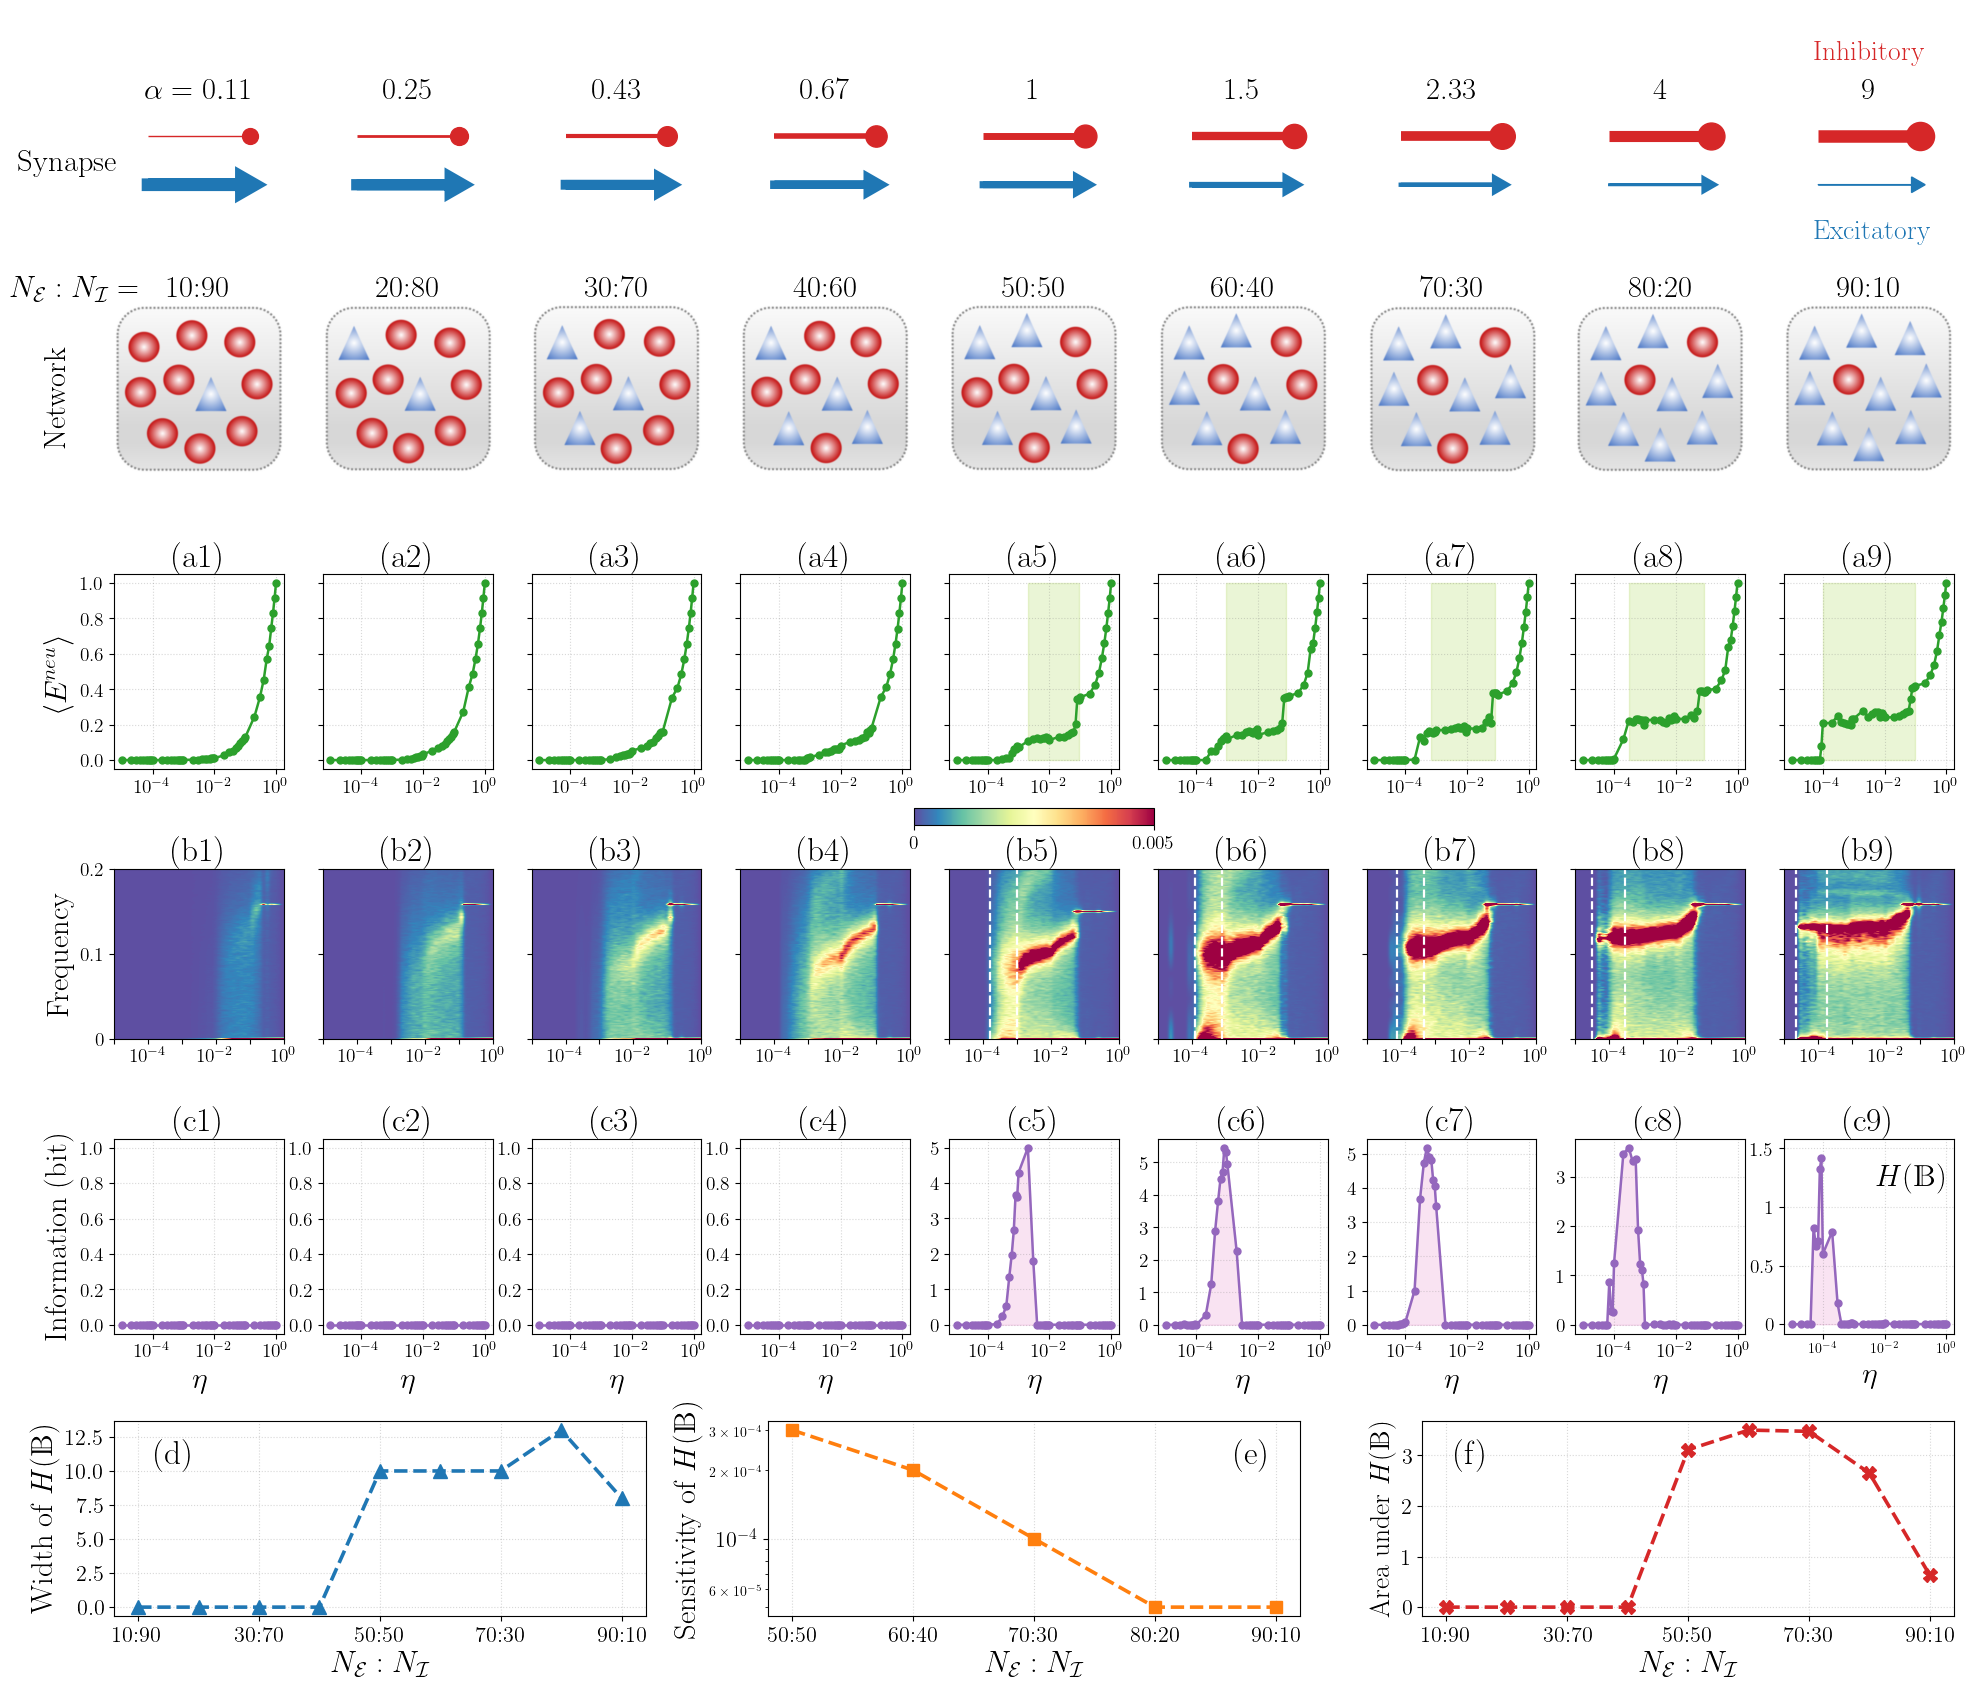

In [23]:
# Plotting Figure 3

import matplotlib.patches as patches

node_energy = np.loadtxt('mean_acivity_matrix_balanced.txt')

ff=22  #font size
ll=15  #line width for vertical and horizental lines
ll_plots=2
a=0.3  #alpha for vertical green lines

x_ax=[0.11, 0.25, 0.43, 0.67, 1, 1.5, 2.33, 4, 9]
eta=[0.00005, 0.0005, 0.005, 0.05, 0.5]
syms=[':o', ':s', ':^', ':D']
y=[0,0.25,0.5,0.75,1]

fig, axes = plt.subplots(nrows=6, ncols=9, figsize=(20,17))

############################################
x_start_I, y_start_I = 0.2, 0.35
x_end_I, y_end_I = 0.8, 0.35

x_start_E, y_start_E = 0.2, 0.1
dx_E, dy_E = 0.55, 0

circle_size=130
dr = 35

head_length_arrow = 0.08
head_width_arrow = 0.08

title_pad_value = 0.5

# WE:WI = 9:1
ax1 = plt.subplot(6,9,1)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=9)
plt.title(r'$\alpha=0.11$',fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 8:2
ax1 = plt.subplot(6,9,2)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=8)
plt.title('0.25', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 7:3
ax1 = plt.subplot(6,9,3)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+2*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=7)
plt.title('0.43', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 6:4
ax1 = plt.subplot(6,9,4)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=4)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+3*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=6)
plt.title('0.67', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 5:5
ax1 = plt.subplot(6,9,5)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+4*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=5)
plt.title('1', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 4:6
ax1 = plt.subplot(6,9,6)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=6)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+5*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=4)
plt.title('1.5', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 3:7
ax1 = plt.subplot(6,9,7)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=7)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+6*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=3)
plt.title('2.33', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 2:8
ax1 = plt.subplot(6,9,8)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+7*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=2)
plt.title('4', fontsize=ff, y=title_pad_value)
plt.axis('off')


# WE:WI = 1:9
ax1 = plt.subplot(6,9,9)
plt.hlines(y=0.35, xmin=x_start_I, xmax=x_end_I, colors='C3', lw=9)
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(x_end_I, y_end_I, s=circle_size+8*dr, c='C3')
plt.arrow(x_start_E, y_start_E, dx_E, dy_E, head_width=head_width_arrow, 
          head_length=head_length_arrow, fc='C0', ec='C0', overhang=0, lw=1)
plt.title('9', fontsize=ff, y=title_pad_value)
plt.axis('off')

########################################################
# Load the image
# For E:10
ax10 = plt.subplot(6,9,10)
plt.axis('off')
image_file = 'E10I90.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,10)
axFig.imshow(image, interpolation='bicubic')
plt.title('10:90', fontsize=ff)
axFig.axis('off')


# For E:20
ax10 = plt.subplot(6,9,11)
plt.axis('off')
image_file = 'E20I80.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,11)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('20:80', fontsize=ff)
axFig.axis('off')


# For E:30
ax10 = plt.subplot(6,9,12)
plt.axis('off')
image_file = 'E30I70.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,12)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('30:70', fontsize=ff)
axFig.axis('off')


# For E:40
ax10 = plt.subplot(6,9,13)
plt.axis('off')
image_file = 'E40I60.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,13)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('40:60', fontsize=ff)
axFig.axis('off')


# For E:50
ax10 = plt.subplot(6,9,14)
plt.axis('off')
image_file = 'E50I50.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,14)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('50:50', fontsize=ff)
axFig.axis('off')


# For E:60
ax10 = plt.subplot(6,9,15)
plt.axis('off')
image_file = 'E60I40.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,15)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('60:40', fontsize=ff)
axFig.axis('off')


# For E:70
ax10 = plt.subplot(6,9,16)
plt.axis('off')
image_file = 'E70I30.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,16)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('70:30', fontsize=ff)
axFig.axis('off')


# For E:80
ax10 = plt.subplot(6,9,17)
plt.axis('off')
image_file = 'E80I20.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,17)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('80:20', fontsize=ff)
axFig.axis('off')


# For E:90
ax10 = plt.subplot(6,9,18)
plt.axis('off')
image_file = 'E90I10.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(6,9 ,18)
axFig.imshow(image, interpolation='bicubic')
#axFig.set_title('(a) Schematic network', fontsize=fs)
plt.title('90:10', fontsize=ff)
axFig.axis('off')

####################################################
ll=1.6
colormap='Spectral_r'    #'terrain_r'
y_ticks = [0, .5, 1]
y_ticks_label = [0, 0.1, 0.2]
x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
x_ticks_label = ['','$10^{-4}$', '', '$10^{-2}$', '', '$10^{0}$']


# For E:10
plt.subplot(6,9 ,28)
plt.imshow(d10, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=y_ticks_label)
plt.ylabel('Frequency', fontsize=ff)
plt.title('(b1)', fontsize=ff+2)

# For E:20
plt.subplot(6,9 ,29)
plt.imshow(d20, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.title('(b2)', fontsize=ff+2)

# For E:30
plt.subplot(6,9 ,30)
plt.imshow(d30, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.title('(b3)', fontsize=ff+2)

# For E:40
plt.subplot(6,9 ,31)
plt.imshow(d40, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.title('(b4)', fontsize=ff+2)

# For E:50
plt.subplot(6,9 ,32)
im=plt.imshow(d50, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.plot([0.4,0.4],[0,1], '--', linewidth = ll, color='white')
plt.plot([0.24,0.24],[0,1], '--', linewidth = ll, color='white')
plt.title('(b5)', fontsize=ff+2)


# Create a new axes for the color bar
cbar_ax = fig.add_axes([0.46, 0.515, 0.12, 0.01])  # [left, bottom, width, height]
cbar = fig.colorbar(im, orientation='horizontal', cax=cbar_ax)
cbar.set_ticks([0, 0.005])  # Set the positions of the ticks
cbar.set_ticklabels([0, 0.005],fontsize=ff-8)  # Set the corresponding labels


# For E:60
plt.subplot(6,9 ,33)
plt.imshow(d60, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.plot([0.38,0.38],[0,1], '--', linewidth = ll, color='white')
plt.plot([0.22,0.22],[0,1], '--', linewidth = ll, color='white')
plt.title('(b6)', fontsize=ff+2)


# For E:70
plt.subplot(6,9 ,34)
plt.imshow(d70, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.plot([0.34,0.34],[0,1], '--', linewidth = ll, color='white')
plt.plot([0.18,0.18],[0,1], '--', linewidth = ll, color='white')
plt.title('(b7)', fontsize=ff+2)


# For E:80
plt.subplot(6,9 ,35)
plt.imshow(d80, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.plot([0.29,0.29],[0,1], '--', linewidth = ll, color='white')
plt.plot([0.1,0.1],[0,1], '--', linewidth = ll, color='white')
plt.title('(b8)', fontsize=ff+2)


# For E:90
plt.subplot(6,9 ,36)
im=plt.imshow(d90, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xticks(ticks=x_ticks, labels=x_ticks_label)
plt.yticks(ticks=y_ticks, labels=[])
plt.plot([0.25,0.25],[0,1], '--', linewidth = ll, color='white')
plt.plot([0.07,0.07],[0,1], '--', linewidth = ll, color='white')
plt.title('(b9)', fontsize=ff+2)


####################################################################
# Plotting node-energy
#node_energy = np.round(np.loadtxt('mean_acivity_matrix_balanced.txt'),2)
m_size=5
ll=1.8

curve_color='C2'

# For E:10
plt.subplot(6,9 ,19)
node_data=node_energy[0,:]
plt.plot(Np, node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.ylabel(r'$\langle E^{neu} \rangle$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a1)', fontsize=ff+2)


# For E:20
plt.subplot(6,9 ,20)
node_data=node_energy[1,:]
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.yticks(x_ticks, labels=[])
plt.xticks(fontsize=ff-8)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a2)', fontsize=ff+2)


# For E:30
plt.subplot(6,9 ,21)
node_data=node_energy[2,:]
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a3)', fontsize=ff+2)


# For E:40
plt.subplot(6,9 ,22)
node_data=node_energy[3,:]
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a4)', fontsize=ff+2)

# For E:50
plt.subplot(6,9 ,23)
node_data=node_energy[4,:]
plt.fill_betweenx(y=[0, 1], x1=0.002, x2=0.09, color='yellowgreen', alpha=0.2)
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a5)', fontsize=ff+2)


# For E:60
plt.subplot(6,9 ,24)
node_data=node_energy[5,:]
plt.fill_betweenx(y=[0, 1], x1=0.0009, x2=0.08, color='yellowgreen', alpha=0.2)
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a6)', fontsize=ff+2)


# For E:70
plt.subplot(6,9 ,25)
node_data=node_energy[6,:]
plt.fill_betweenx(y=[0, 1], x1=0.0007, x2=0.08, color='yellowgreen', alpha=0.2)
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a7)', fontsize=ff+2)


# For E:80
plt.subplot(6,9 ,26)
node_data=node_energy[7,:]
plt.fill_betweenx(y=[0, 1], x1=0.0003, x2=0.08, color='yellowgreen', alpha=0.2)
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a8)', fontsize=ff+2)


# For E:90
plt.subplot(6,9 ,27)
node_data=node_energy[8,:]
plt.fill_betweenx(y=[0, 1], x1=0.0001, x2=0.1, color='yellowgreen', alpha=0.2)
plt.plot(Np,node_data,'-o', ms=m_size, color=curve_color, lw=ll)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(x_ticks, labels=[])
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(a9)', fontsize=ff+2)

###################################################################
# Plotting information curves
curve_color='C4'
x_ticks=[0,9.2,18.4,27.6,36.8,45]
x_labels=['$10^{-5}$','','$10^{-3}$','','$10^{-1}$','$1$']
xx=np.arange(46)

# For E:10
plt.subplot(6,9 ,37)
plt.plot(Np,hB10,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
#plt.xticks(x_ticks, labels=x_labels)
plt.ylabel('Information (bit)', fontsize=ff)
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c1)', fontsize=ff+2)
plt.ylim([-0.05,1.05])


# For E:20
plt.subplot(6,9 ,38)
plt.plot(Np,hB20,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c2)', fontsize=ff+2)
plt.ylim([-0.05,1.05])


# For E:30
plt.subplot(6,9 ,39)
plt.plot(Np,hB30,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c3)', fontsize=ff+2)
plt.ylim([-0.05,1.05])


# For E:40
plt.subplot(6,9 ,40)
plt.plot(Np,hB40,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c4)', fontsize=ff+2)
plt.ylim([-0.05,1.05])


# For E:50
plt.subplot(6,9 ,41)
plt.plot(Np,hB50,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c5)', fontsize=ff+2)
plt.fill_between(Np,hB50,where=(Np<=40), color= 'C6', alpha=0.2)


# For E:60
plt.subplot(6,9 ,42)
plt.plot(Np,hB60,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c6)', fontsize=ff+2)
plt.fill_between(Np,hB60,where=(Np<=40), color= 'C6', alpha=0.2)


# For E:70
plt.subplot(6,9 ,43)
plt.plot(Np,hB70,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c7)', fontsize=ff+2)
plt.fill_between(Np,hB70,where=(Np<=40), color= 'C6', alpha=0.2)


# For E:80
plt.subplot(6,9 ,44)
plt.plot(Np,hB80,'-o', color=curve_color, markersize=m_size, lw=ll)
plt.yticks(fontsize=ff-8)
plt.xticks(fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c8)', fontsize=ff+2)
plt.fill_between(Np,hB80,where=(Np<=40), color= 'C6', alpha=0.2)


# For E:90
ax=plt.subplot(6,9 ,45)
plt.plot(Np,hB90,'-o', color=curve_color, markersize=m_size, lw=ll, label=r'$H(\mathds{B})$')
plt.yticks([0,0.5,1,1.5], [0,0.5,1,1.5], fontsize=ff-8)
plt.xscale('log')
plt.xlabel(r'$\eta$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.title('(c9)', fontsize=ff+2)
plt.ylim([-0.08,1.58])
plt.fill_between(Np,hB90,where=(Np<=40), color= 'C6', alpha=0.2)  #, label='$Intermittent$'
#plt.legend(loc='upper right', fontsize=ff,frameon=False)
ax.text(0.75, 0.8, r'$H(\mathds{B})$', transform=ax.transAxes,
    fontsize=ff, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))

#not plot axis
for i in np.arange(9):
    plt.subplot(6,9 ,46+i)
    plt.axis('off')
###################################################################


plt.subplot(6,3 ,16)
entropy_width=[0,0,0,0,10,10,10,13,8]
plt.plot(entropy_width, '--^', color='C0', markersize=m_size+5, lw=ll+0.8)
plt.xticks([0,2,4,6,8], labels=['10:90', '30:70', '50:50', '70:30', '90:10'], fontsize=ff-6)
plt.yticks(fontsize=ff-6)
plt.ylabel('Width of~'+r'$H(\mathds{B})$', fontsize=ff)
plt.xlabel(r'$N_{\mathcal{E}}:N_{\mathcal{I}}$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)


plt.subplot(6,3 ,17)
entropy_start_point=[11,10,9,4,4]
entropy_start_eta=[0.0003,0.0002,0.0001,0.00005,0.00005]
plt.plot(entropy_start_eta, '--s', color='C1', markersize=m_size+4, lw=ll+0.8)
plt.xticks([0,1,2,3,4], labels=['50:50','60:40', '70:30', '80:20', '90:10'], fontsize=ff-6)
plt.yticks(fontsize=ff-6)
plt.ylabel('Sensitivity of~'+r'$H(\mathds{B})$', fontsize=ff)
plt.xlabel(r'$N_{\mathcal{E}}:N_{\mathcal{I}}$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.yscale('log')


# Plotting the area under information curves
plt.subplot(6,3 ,18)
plt.plot(area_under_entropy_curve_log, '--X',color='C3', markersize=m_size+5, lw=ll+0.8)
plt.xticks([0,2,4,6,8], labels=['10:90', '30:70', '50:50', '70:30', '90:10'], fontsize=ff-6)
plt.yticks(fontsize=ff-6)
plt.ylabel('Area under~'+r'$H(\mathds{B})$', fontsize=ff-2)
plt.xlabel(r'$N_{\mathcal{E}}:N_{\mathcal{I}}$', fontsize=ff)
plt.grid(linestyle=':', color='C7', alpha=0.3)

################################################################
#plt.figtext(0.015, 0.942, r'$\alpha=$', fontsize=ff, bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.91, 0.86, 'Excitatory', color='C0', fontsize=ff-2,bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.91, 0.965, 'Inhibitory', color='C3', fontsize=ff-2,bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.012, 0.9, 'Synapse', fontsize=ff, bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.008, 0.826, r'$N_{\mathcal{E}}:N_{\mathcal{I}}=$', fontsize=ff, bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.025, 0.74, 'Network', fontsize=ff, rotation=90, bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.08, 0.14, '(d)', fontsize=ff+2, bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.62, 0.14, '(e)', fontsize=ff+2, bbox=dict(facecolor='none', edgecolor='none'))
plt.figtext(0.73, 0.14, '(f)', fontsize=ff+2, bbox=dict(facecolor='none', edgecolor='none'))


plt.subplots_adjust(top=0.995, bottom=0.05, left=0.06, right=0.98, hspace=0.45, wspace=0.23)
#plt.savefig('fig4.pdf')  #, dpi=600)

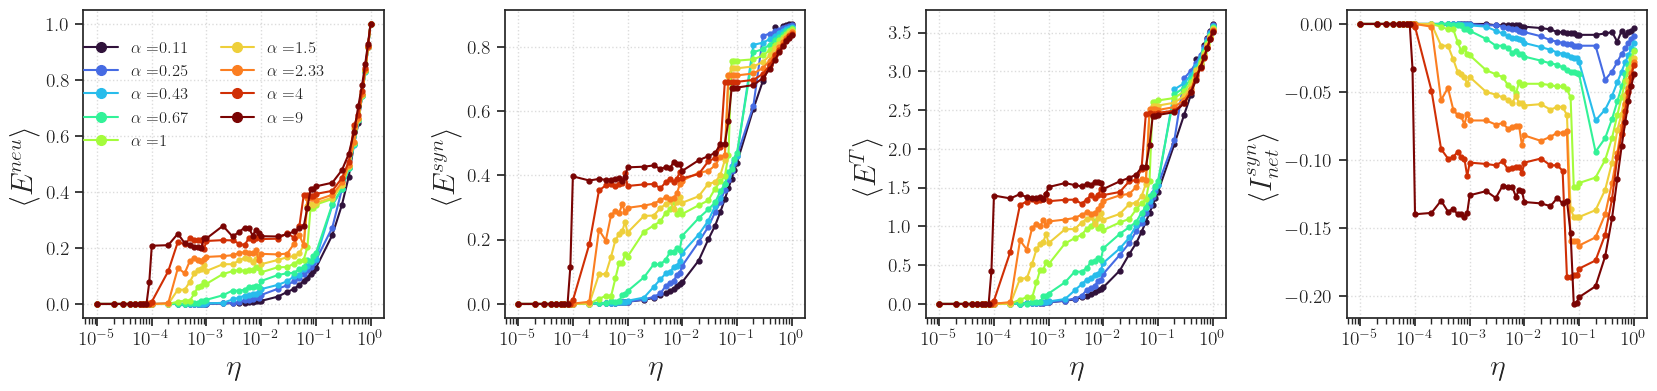

In [68]:
# Plotting what Dr Valizede ordered
node_energy = np.loadtxt('mean_acivity_matrix_balanced.txt')
synapse_energy = np.loadtxt('mean_synaptic_energy_matrix_balanced.txt')
synaptic_current= np.loadtxt('mean_synaptic_current_matrix_balanced.txt')
c=3
marker_size=3.5

x_ax=[0.11, 0.25, 0.43, 0.67, 1, 1.5, 2.33, 4, 9]

n = 9
colors = plt.cm.turbo(np.linspace(0,1,n))

plt.figure(figsize=(17,4))

plt.subplot(1,4,1)
for row in np.arange(9):
    node_data=node_energy[row,:]
    plt.plot(Np,node_data,'-o', ms=marker_size, color=colors[row], label=r'$\alpha=$'+str(x_ax[row]) )
    plt.xscale('log')
    plt.ylabel(r'$\langle E^{neu} \rangle$',fontsize=ff)
    plt.xlabel(r'$\eta$',fontsize=ff)
    plt.grid(linestyle=':', color='C7', alpha=0.3)
    plt.xticks(fontsize=ff-8)
    plt.yticks(fontsize=ff-8)
    plt.legend(fontsize=ff-10, bbox_to_anchor=(0.85, 0.5),frameon=False,
          fancybox=False, shadow=False, ncol=2, markerscale=2, scatterpoints=1)
    
plt.subplot(1,4,2)
for row in np.arange(9):
    synapse_data=synapse_energy[row,:]
    plt.plot(Np,synapse_data,'-o', ms=marker_size, color=colors[row] )
    plt.xscale('log')
    plt.xlabel(r'$\eta$',fontsize=ff)
    plt.ylabel(r'$\langle E^{syn} \rangle$',fontsize=ff)
    plt.grid(linestyle=':', color='C7', alpha=0.3)
    plt.xticks(fontsize=ff-8)
    plt.yticks(fontsize=ff-8)
    #plt.title('(r)', fontsize=ff+2)

plt.subplot(1,4,3)
for row in np.arange(9):
    total_data=node_energy[row,:]+c*synapse_energy[row,:]
    plt.plot(Np,total_data,'-o', ms=marker_size, color=colors[row] )
    plt.xscale('log')
    plt.xlabel(r'$\eta$',fontsize=ff)
    plt.ylabel(r'$\langle E^{T} \rangle$',fontsize=ff)
    plt.grid(linestyle=':', color='C7', alpha=0.3)
    plt.xticks(fontsize=ff-8)
    plt.yticks(fontsize=ff-8)
    #plt.title('(r)', fontsize=ff+2)

plt.subplot(1,4,4)
for row in np.arange(9):
    current=synaptic_current[row,:]
    plt.plot(Np,current,'-o', ms=marker_size, color=colors[row], label=r'$\alpha=$'+str(x_ax[row]) )
    plt.xscale('log')
    plt.ylabel(r'$\langle I_{net}^{syn} \rangle$',fontsize=ff)
    plt.xlabel(r'$\eta$',fontsize=ff)
    plt.grid(linestyle=':', color='C7', alpha=0.3)
    plt.xticks(fontsize=ff-8)
    plt.yticks(fontsize=ff-8)
    
plt.subplots_adjust(top=0.95, bottom=0.18, left=0.06, right=0.98, hspace=0.5, wspace=.4)
plt.savefig('HorEta.png')

In [ ]:
'''
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize =([7, 4]))
gs = gridspec.GridSpec(2, 6)
gs.update(wspace = 1.5, hspace = 0.3)

ax1 = plt.subplot(gs[0, :2])
ax1.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
'''

In [17]:
# Loading data for the next plot
c=3
mean_total_energy_eta5=( np.loadtxt('mean_acivity_matrix_eta1.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta1.txt') )/(c+1)
mean_total_energy_eta05=( np.loadtxt('mean_acivity_matrix_eta05.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta05.txt') )/(c+1)
mean_total_energy_eta005=( np.loadtxt('mean_acivity_matrix_eta005.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta005.txt') )/(c+1)
mean_total_energy_eta0005=( np.loadtxt('mean_acivity_matrix_eta0005.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta0005.txt') )/(c+1)

mean_synaptic_current_eta5=np.loadtxt('mean_synaptic_current_matrix_eta1.txt')
mean_synaptic_current_eta05=np.loadtxt('mean_synaptic_current_matrix_eta05.txt')
mean_synaptic_current_eta005=np.loadtxt('mean_synaptic_current_matrix_eta005.txt')
mean_synaptic_current_eta0005=np.loadtxt('mean_synaptic_current_matrix_eta0005.txt')

ff=22  #font size
ll=15  #line width for vertical and horizental lines
ll_plots=1.5
m_size=6
a=0.3  #alpha for vertical green lines
c=3  #coefision of synapses energy 

x_ax=[0.11, 0.25, 0.43, 0.67, 1, 1.5, 2.33, 4, 9]
eta=[0.0005, 0.005, 0.05, 0.1]
syms=['-o', '-s', '-^', '-X']
y=[0,0.25,0.5,0.75,1]

etas=[0.0005, 0.005, 0.05, 0.1]
Wi=[0.11, 0.25, 0.43, 0.67, 1, 1.5, 2.33, 4, 9]
syms=['-o', '-s', '-^', '-X']
ticks_position=[0,0.5, 1.,  1.5, 2.,  2.5, 3.,  3.5, 4.,  4.5, 5.,  5.5, 6.,  6.5, 7.,  7.5, 8.,  8.5,
 9.]
ticks_label=['',  0.11 ,'',  '', '',  0.43, '',  '', '',  1, '',  '', '',  2.33, '',  '', '',  9,
 '' ]
xx=np.arange(0.1,9.1,0.1)
line_width = 2
ll_colomaps = 2.5
marker_size = 8
#sns.set(style="ticks")


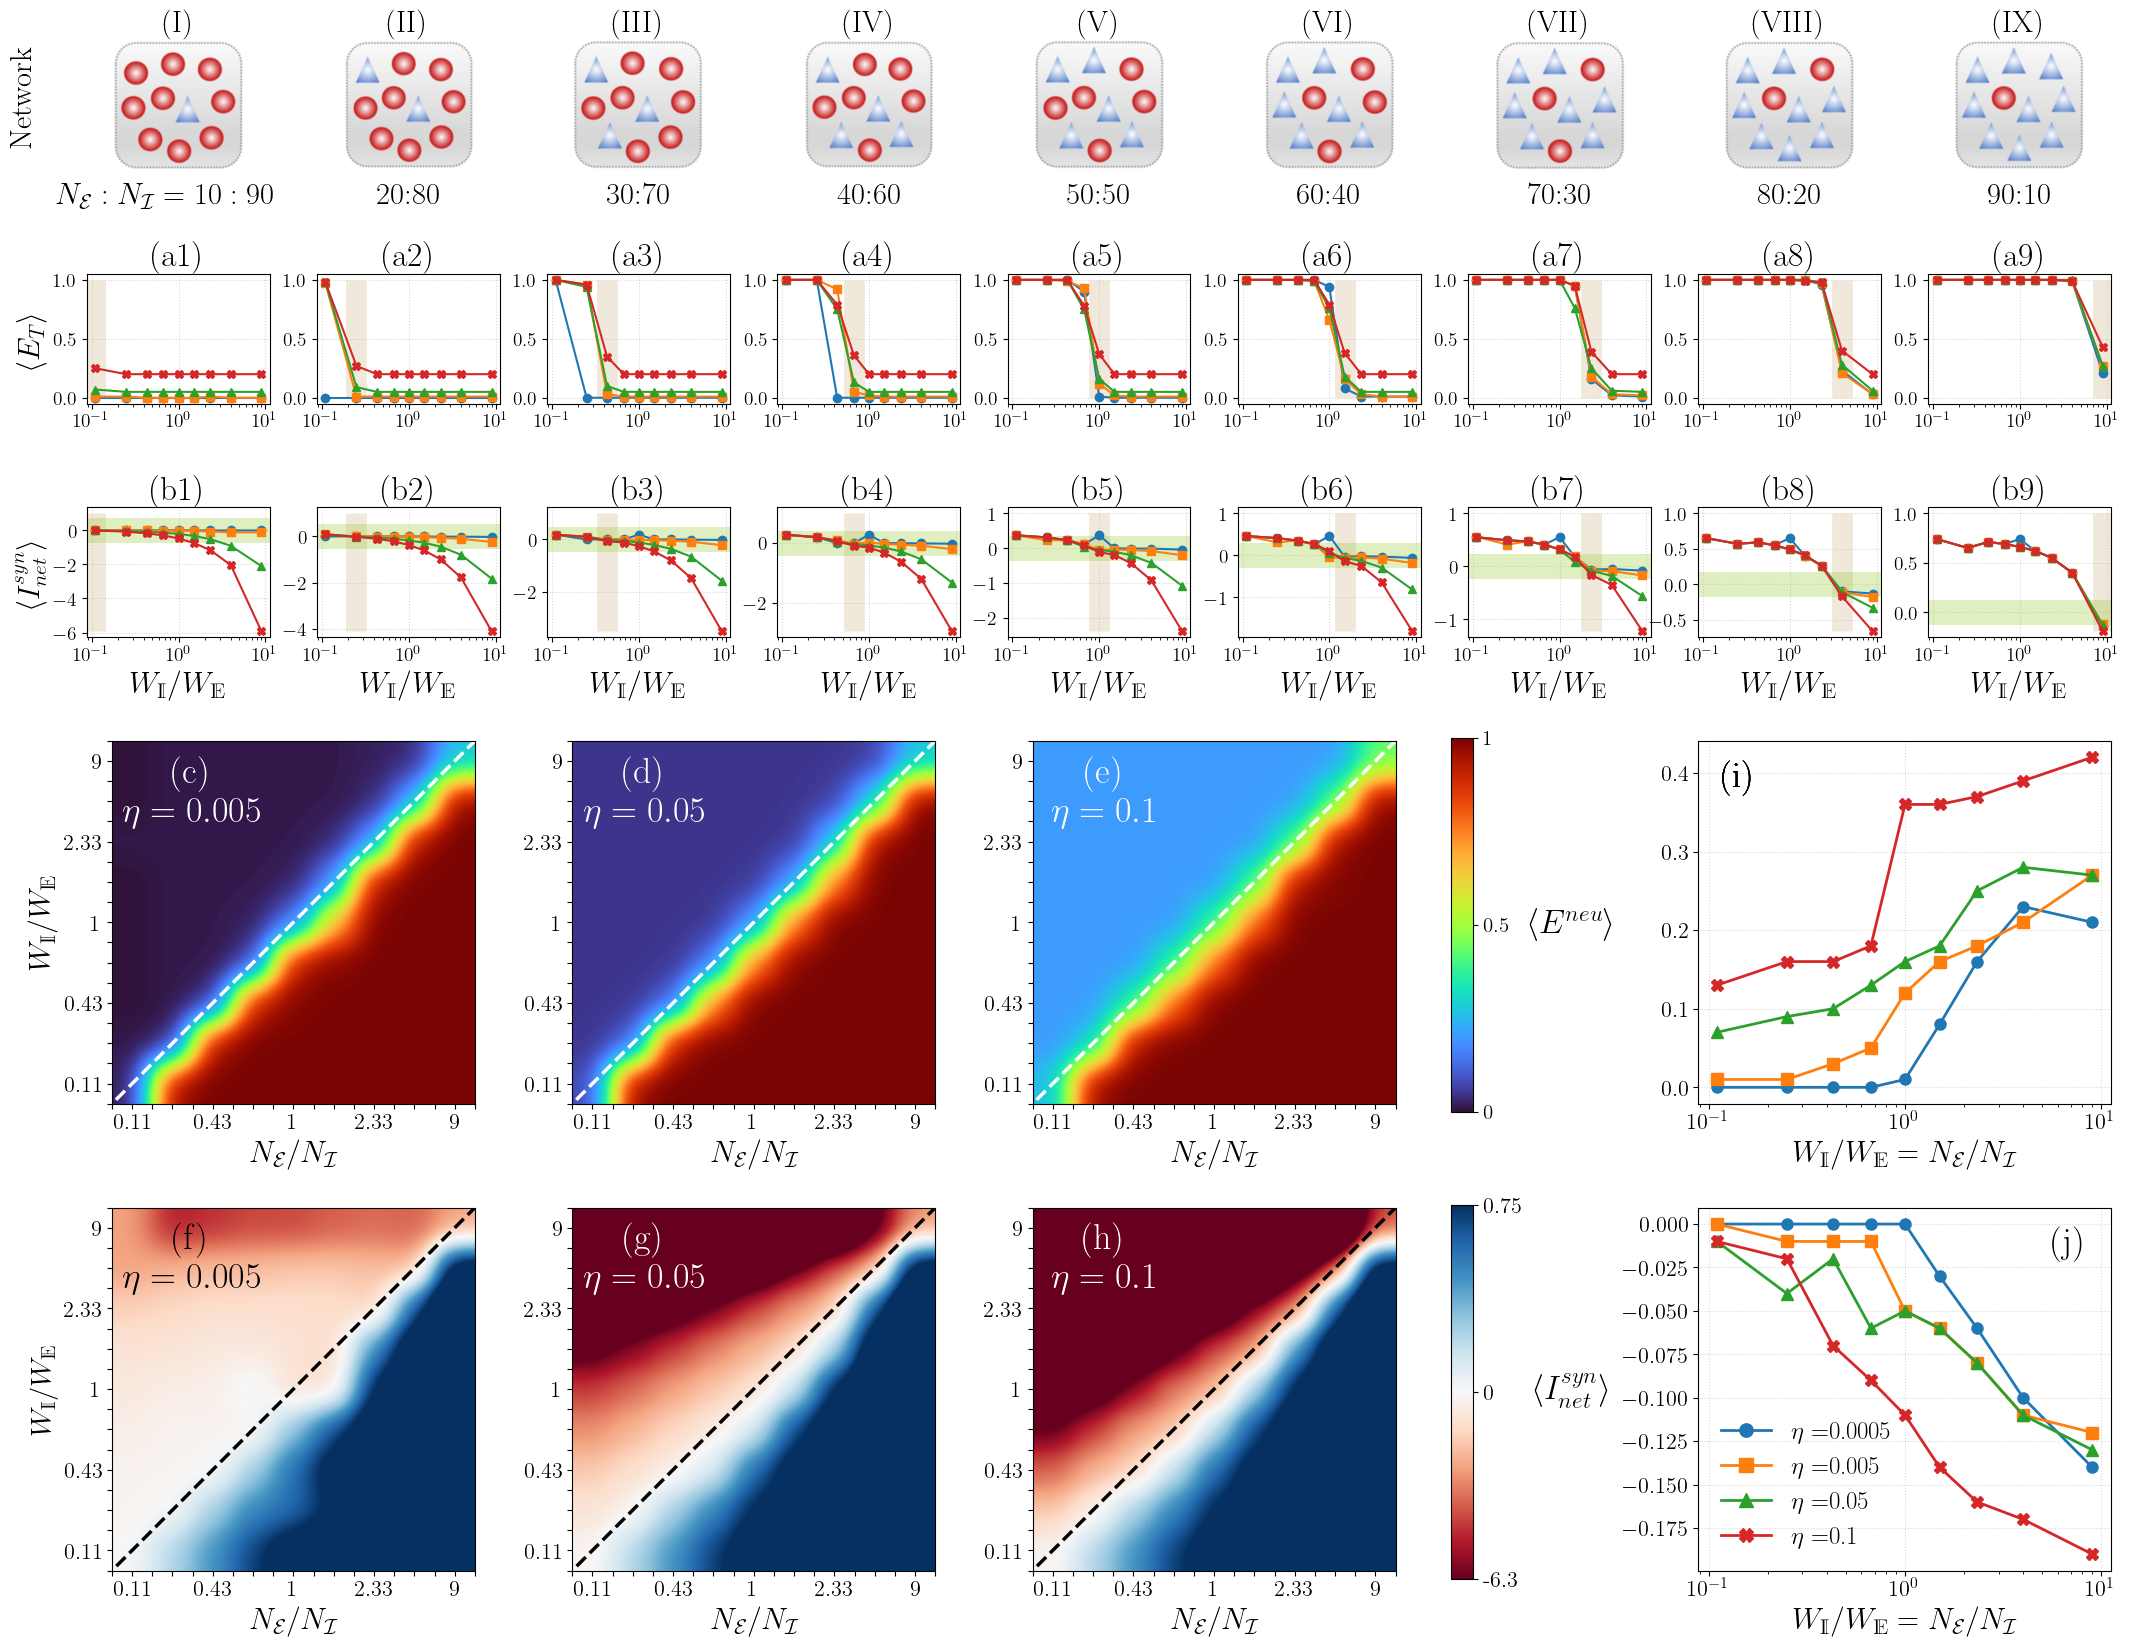

In [39]:
# Plotting mean_energy and mean_synaptic_current
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Loading data for the plot
mean_total_energy_eta5=( np.loadtxt('mean_acivity_matrix_eta1.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta1.txt') )/(c+1)
mean_total_energy_eta05=( np.loadtxt('mean_acivity_matrix_eta05.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta05.txt') )/(c+1)
mean_total_energy_eta005=( np.loadtxt('mean_acivity_matrix_eta005.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta005.txt') )/(c+1)
mean_total_energy_eta0005=( np.loadtxt('mean_acivity_matrix_eta0005.txt')+c*np.loadtxt('mean_synaptic_energy_matrix_eta0005.txt') )/(c+1)

mean_synaptic_current_eta5=np.loadtxt('mean_synaptic_current_matrix_eta1.txt')
mean_synaptic_current_eta05=np.loadtxt('mean_synaptic_current_matrix_eta05.txt')
mean_synaptic_current_eta005=np.loadtxt('mean_synaptic_current_matrix_eta005.txt')
mean_synaptic_current_eta0005=np.loadtxt('mean_synaptic_current_matrix_eta0005.txt')

ff=22  #font size
ll=15  #line width for vertical and horizental lines
ll_plots=1.5
m_size=6
c=3  #coefision of synapses energy 

x_ax=[0.11, 0.25, 0.43, 0.67, 1, 1.5, 2.33, 4, 9]
eta=[0.0005, 0.005, 0.05, 0.1]
syms=['-o', '-s', '-^', '-X']
y=[0,0.25,0.5,0.75,1]

etas=[0.0005, 0.005, 0.05, 0.1]
Wi=[0.11, 0.25, 0.43, 0.67, 1, 1.5, 2.33, 4, 9]
syms=['-o', '-s', '-^', '-X']
ticks_position=[0,0.5, 1.,  1.5, 2.,  2.5, 3.,  3.5, 4.,  4.5, 5.,  5.5, 6.,  6.5, 7.,  7.5, 8.,  8.5,
 9.]
ticks_label=['',  0.11 ,'',  '', '',  0.43, '',  '', '',  1, '',  '', '',  2.33, '',  '', '',  9,
 '' ]
xx=np.arange(0.1,9.1,0.1)
line_width = 2
ll_colomaps = 2.5
marker_size = 8

############################
fig = plt.figure(figsize =([22, 17]))
gs = gridspec.GridSpec(7, 9)
#gs.update(wspace = 0.5, hspace = 0.3)

# For E:10
plt.subplot(gs[1,0])
plt.vlines(x = 0.11, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,0]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,0]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,0]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,0]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.ylabel(r'$\langle E_T \rangle$',fontsize=ff, rotation=90)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a1)', fontsize=ff+2)



# For E:20
plt.subplot(gs[1,1])
plt.vlines(x = 0.25, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,1]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,1]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,1]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,1]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a2)', fontsize=ff+2)


# For E:30
plt.subplot(gs[1,2])
plt.vlines(x = 0.43, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,2]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,2]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,2]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,2]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a3)', fontsize=ff+2)


# For E:40
plt.subplot(gs[1,3])
plt.vlines(x = 0.67, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,3]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,3]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,3]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,3]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a4)', fontsize=ff+2)
    


# For E:50
plt.subplot(gs[1,4])
plt.vlines(x = 1, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,4]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,4]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,4]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,4]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a5)', fontsize=ff+2)


# For E:60
plt.subplot(gs[1,5])
plt.vlines(x = 1.5, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,5]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,5]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,5]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,5]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a6)', fontsize=ff+2)


# For E:70
plt.subplot(gs[1,6])
plt.vlines(x = 2.33, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,6]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,6]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,6]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,6]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a7)', fontsize=ff+2)


# For E:80
plt.subplot(gs[1,7])
plt.vlines(x = 4, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,7]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,7]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,7]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,7]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a8)', fontsize=ff+2)


# For E:90
plt.subplot(gs[1,8])
plt.vlines(x = 9, ymin = 0, ymax = 1, colors = 'tan', alpha=a, lw=ll)
mean_energy_0005 = mean_total_energy_eta0005[:,8]
plt.plot(x_ax, mean_energy_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_energy_005 = mean_total_energy_eta005[:,8]
plt.plot(x_ax, mean_energy_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_energy_05 = mean_total_energy_eta05[:,8]
plt.plot(x_ax, mean_energy_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
mean_energy_5 = mean_total_energy_eta5[:,8]
plt.plot(x_ax, mean_energy_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
#plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(a9)', fontsize=ff+2)

######################################################

# For E:10
plt.subplot(gs[2,0])
mean_current_5 = mean_synaptic_current_eta5[:,0]
plt.vlines(x = 0.11, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,0]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,0]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,0]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.ylabel(r'$\langle I_{net}^{syn} \rangle$',fontsize=ff, rotation=90)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b1)', fontsize=ff+2)


# For E:20
plt.subplot(gs[2,1])
mean_current_5 = mean_synaptic_current_eta5[:,1]
plt.vlines(x = 0.25, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,1]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,1]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,1]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b2)', fontsize=ff+2)
    

# For E:30
plt.subplot(gs[2,2])
mean_current_5 = mean_synaptic_current_eta5[:,2]
plt.vlines(x = 0.43, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,2]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,2]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,2]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b3)', fontsize=ff+2)


# For E:40
plt.subplot(gs[2,3])
mean_current_5 = mean_synaptic_current_eta5[:,3]
plt.vlines(x = 0.67, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,3]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,3]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,3]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b4)', fontsize=ff+2)


# For E:50
plt.subplot(gs[2,4])
mean_current_5 = mean_synaptic_current_eta5[:,4]
plt.vlines(x = 1, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,4]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,4]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,4]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b5)', fontsize=ff+2)


# For E:60
plt.subplot(gs[2,5])
mean_current_5 = mean_synaptic_current_eta5[:,5]
plt.vlines(x = 1.5, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,5]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,5]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,5]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b6)', fontsize=ff+2)


# For E:70
plt.subplot(gs[2,6])
mean_current_5 = mean_synaptic_current_eta5[:,6]
plt.vlines(x = 2.33, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,6]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,6]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,6]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b7)', fontsize=ff+2)


# For E:80
plt.subplot(gs[2,7])
mean_current_5 = mean_synaptic_current_eta5[:,7]
plt.vlines(x = 4, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,7]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,7]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,7]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b8)', fontsize=ff+2)


# For E:90
plt.subplot(gs[2,8])
mean_current_5 = mean_synaptic_current_eta5[:,8]
plt.vlines(x = 9, ymin = min(mean_current_5), ymax = 1, colors = 'tan', alpha=a, lw=ll)
plt.axhline(y = 0, color='yellowgreen', alpha=a, lw=ll+3)
mean_current_0005 = mean_synaptic_current_eta0005[:,8]
plt.plot(x_ax, mean_current_0005, syms[0], label=r'$\eta = $'+str(eta[0]), lw=ll_plots, ms=m_size)
mean_current_005 = mean_synaptic_current_eta005[:,8]
plt.plot(x_ax, mean_current_005, syms[1], label=r'$\eta = $'+str(eta[1]), lw=ll_plots, ms=m_size)
mean_current_05 = mean_synaptic_current_eta05[:,8]
plt.plot(x_ax, mean_current_05, syms[2], label=r'$\eta = $'+str(eta[2]), lw=ll_plots, ms=m_size)
plt.plot(x_ax, mean_current_5, syms[3], label=r'$\eta = $'+str(eta[3]), lw=ll_plots, ms=m_size)
plt.xlabel(r'$W_\mathds{I} / W_\mathds{E}$',fontsize=ff, rotation=0)
plt.grid(linestyle=':', color='C7', alpha=0.3)
plt.xscale('log')
plt.xticks(fontsize=ff-8)
plt.yticks(fontsize=ff-8)
plt.title('(b9)', fontsize=ff+2)

#############################################################
# Load the image
# For E:10
ax1 = plt.subplot(gs[0,0])
plt.axis('off')
image_file = 'E10I90.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,0])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.4, -0.2, r'$N_{\mathcal{E}}:N_{\mathcal{I}}=10:90$', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(I)', fontsize=ff)  #, loc='center', y=0.5)
#plt.text(0.1, 0.1, 'Network structure\n', fontsize=ff, rotation=90)
axFig.axis('off')


# For E:20
ax2 = plt.subplot(gs[0,1])
plt.axis('off')
image_file = 'E20I80.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,1])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '20:80', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(II)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:30
ax3 = plt.subplot(gs[0,2])
plt.axis('off')
image_file = 'E30I70.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,2])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '30:70', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(III)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:40
ax4 = plt.subplot(gs[0,3])
plt.axis('off')
image_file = 'E40I60.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,3])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '40:60', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(IV)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:50
ax5 = plt.subplot(gs[0,4])
plt.axis('off')
image_file = 'E50I50.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,4])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '50:50', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(V)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:60
ax6 = plt.subplot(gs[0,5])
plt.axis('off')
image_file = 'E60I40.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,5])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '60:40', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(VI)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:70
ax7 = plt.subplot(gs[0,6])
plt.axis('off')
image_file = 'E70I30.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,6])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '70:30', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(VII)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:80
ax8 = plt.subplot(gs[0,7])
plt.axis('off')
image_file = 'E80I20.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,7])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '80:20', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(VIII)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')


# For E:90
ax9 = plt.subplot(gs[0,8])
plt.axis('off')
image_file = 'E90I10.png'
image = plt.imread(image_file)
axFig=fig.add_subplot(gs[0,8])
axFig.imshow(image, interpolation='bicubic')
plt.text(0.5, -0.2, '90:10', ha='center', va='center', fontsize=ff, transform=plt.gca().transAxes)
plt.title('(IX)', fontsize=ff)  #, loc='center', y=0.5)
axFig.axis('off')

##########################################################
# Plotting mean_activity and mean_net_current colormaps

c=0  # since we are obtaining only mean_activity on neurons

colormap='turbo'
ax=plt.subplot(gs[3:5,0:2])
d_neuron = np.loadtxt('mean_acivity_matrix_eta005.txt')
d_synapse = np.loadtxt('mean_synaptic_energy_matrix_eta005.txt')
d = (d_neuron + c*d_synapse)/(c+1)
im = plt.imshow(d, cmap =colormap, 
        interpolation ='gaussian', origin ='lower', vmin = 0, vmax = 1, extent=[0,9,0,9])
plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$', fontsize=ff)
plt.ylabel(r'$W_{\mathds{I}} / W_{\mathds{E}}$', fontsize=ff)
#plt.title(r'$\eta=0.005$', fontsize=ff+2)
plt.xticks(ticks_position, ticks_label, fontsize=ff-6)
plt.yticks(ticks_position, ticks_label, fontsize=ff-6)
plt.plot(xx,xx, '--', color='white', lw=ll_colomaps)
ax.text(0.22, 0.86, '(c)\n'+r'$\eta=0.005$', transform=ax.transAxes, color='white',
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))


ax=plt.subplot(gs[3:5,2:4])
d_neuron = np.loadtxt('mean_acivity_matrix_eta05.txt')
d_synapse = np.loadtxt('mean_synaptic_energy_matrix_eta05.txt')
d = (d_neuron + c*d_synapse)/(c+1)
im = plt.imshow(d, cmap =colormap, 
        interpolation ='gaussian', origin ='lower', vmin = 0, vmax = 1, extent=[0,9,0,9])
plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$', fontsize=ff)
#plt.title(r'$\eta=0.05$', fontsize=ff+2)
plt.xticks(ticks_position, ticks_label, fontsize=ff-6)
plt.yticks(ticks_position, ticks_label, fontsize=ff-6)
plt.plot(xx,xx, '--', color='white', lw=ll_colomaps)
ax.text(0.2, 0.86, '(d)\n'+r'$\eta=0.05$', transform=ax.transAxes, color='white',
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))



ax=plt.subplot(gs[3:5,4:6])
d_neuron = np.loadtxt('mean_acivity_matrix_eta1.txt')
d_synapse = np.loadtxt('mean_synaptic_energy_matrix_eta1.txt')
d = (d_neuron + c*d_synapse)/(c+1)
im = plt.imshow(d, cmap =colormap, 
        interpolation ='gaussian', origin ='lower', vmin = 0, vmax = 1, extent=[0,9,0,9])
plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$', fontsize=ff)
#plt.title(r'$\eta=0.1$', fontsize=ff+2)
plt.xticks(ticks_position, ticks_label, fontsize=ff-6)
plt.yticks(ticks_position, ticks_label, fontsize=ff-6)
plt.plot(xx,xx, '--', color='white', lw=ll_colomaps)
ax.text(0.2, 0.86, '(e)\n'+r'$\eta=0.1$', transform=ax.transAxes, color='white',
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))



# Create a new axes for the color bar
cbar_ax = fig.add_axes([0.68, 0.33, 0.01, 0.22])  # [left, bottom, width, height]
cbar = fig.colorbar(im, orientation='vertical', cax=cbar_ax)
#cbar.set_label(r'$\langle E_{T} \rangle$', fontsize=ff, rotation=90)  # Set the label for the color bar
# Set ticks and labels for the color bar
cbar.set_ticks([0, 0.5, 1])  # Set the positions of the ticks
cbar.set_ticklabels([0, 0.5, 1],fontsize=ff-7)  # Set the corresponding labels


ax=plt.subplot(gs[3:5,7:])
mean_activity_neuron  = np.loadtxt('mean_activity_at_critical_points.txt')
mean_activity_synapse  = np.loadtxt('mean_synaptic_energy_at_critical_points.txt')
mean_activity = (mean_activity_neuron + c*mean_activity_synapse)/(1+c)
for i in np.arange(4):
    mean_act = mean_activity[:,i+1]
    plt.plot(Wi, np.abs(mean_act), syms[i], label=r'$\eta = $'+str(etas[i]), ms=marker_size, lw=line_width)
    plt.xlabel(r'$W_{\mathds{I}} / W_{\mathds{E}}=N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
    plt.ylabel(r'$\langle E^{neu} \rangle$',fontsize=ff+2, rotation=0)
    plt.grid(linestyle=':', color='C7', alpha=0.3)
    #tit='Mean energy density of neurons \nwhen~'+r'$\frac{N_\mathcal{E}}{N_\mathcal{I}} = \frac{W_{\mathds{I}}}{W_{\mathds{E}}}$'
    #plt.title('(i)', fontsize=ff+2)
    plt.xscale('log')
    #plt.legend(fontsize=ff-4, frameon=False)  #, loc='center left'
    plt.xticks(fontsize=ff-6)
    plt.yticks(fontsize=ff-6)
    #plt.legend(fontsize=ff-2, bbox_to_anchor=(0.07, 0.6),frameon=False,
          #fancybox=False, shadow=False, ncol=1, markerscale=1.2, scatterpoints=1)
    ax.text(0.1, 0.9, '(i)', transform=ax.transAxes,
        fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))
ax.yaxis.set_label_coords(-0.3, 0.45)  # x, y coordinates in axes space



colormap='RdBu'   # 'terrain'
ax=plt.subplot(gs[5:,0:2])
d = np.loadtxt('mean_synaptic_current_matrix_eta005.txt')
im = plt.imshow(d, cmap =colormap, 
        interpolation ='gaussian', origin ='lower', vmin = -0.3, vmax = 0.3, extent=[0,9,0,9])
plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$', fontsize=ff)
plt.ylabel(r'$W_{\mathds{I}} / W_{\mathds{E}}$', fontsize=ff-1)
#plt.title('(d)', fontsize=ff+2)
plt.xticks(ticks_position, ticks_label, fontsize=ff-6)
plt.yticks(ticks_position, ticks_label, fontsize=ff-6)
xx=np.arange(0.11,8.99,0.01)
plt.plot(xx,xx, '--', color='black', lw=ll_colomaps)
ax.text(0.22, 0.86, '(f)\n'+r'$\eta=0.005$', transform=ax.transAxes,
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))



ax=plt.subplot(gs[5:,2:4])
d = np.loadtxt('mean_synaptic_current_matrix_eta05.txt')
im = plt.imshow(d, cmap =colormap, 
        interpolation ='gaussian', origin ='lower', vmin = -0.3, vmax = 0.3, extent=[0,9,0,9])
plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$', fontsize=ff)
#plt.title('(f)', fontsize=ff+2)
plt.xticks(ticks_position, ticks_label, fontsize=ff-6)
plt.yticks(ticks_position, ticks_label, fontsize=ff-6)
plt.plot(xx,xx, '--', color='black', lw=ll_colomaps)
ax.text(0.2, 0.86, '(g)\n'+r'$\eta=0.05$', transform=ax.transAxes, color='white',
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))



ax=plt.subplot(gs[5:,4:6])
d = np.loadtxt('mean_synaptic_current_matrix_eta1.txt')
im = plt.imshow(d, cmap =colormap, 
        interpolation ='gaussian', origin ='lower', vmin = -0.3, vmax = 0.3, extent=[0,9,0,9])
plt.xlabel(r'$N_\mathcal{E} / N_\mathcal{I}$', fontsize=ff)
plt.xticks(ticks_position, ticks_label, fontsize=ff-6)
plt.yticks(ticks_position, ticks_label, fontsize=ff-6)
plt.plot(xx,xx, '--', color='black', lw=ll_colomaps)
ax.text(0.2, 0.86, '(h)\n'+r'$\eta=0.1$', transform=ax.transAxes, color='white',
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))


# Create a new axes for the color bar
cbar_ax = fig.add_axes([0.68, 0.055, 0.01, 0.22])  # [left, bottom, width, height]
cbar = fig.colorbar(im, orientation='vertical', cax=cbar_ax)
#cbar.set_label(r'$\langle I_{net}^{syn} \rangle$', fontsize=ff, rotation=90)  # Set the label for the color bar
# Set ticks and labels for the color bar
cbar.set_ticks([-0.3, 0, 0.3])  # Set the positions of the ticks
cbar.set_ticklabels([-6.3, 0, 0.75],fontsize=ff-6)  # Set the corresponding labels


ax=plt.subplot(gs[5:,7:])
mean_synaptic_current = np.loadtxt('mean_synaptic_current_at_critical_points.txt')
for i in np.arange(4):
    mean_synaptic_curr = mean_synaptic_current[:,i+1]
    plt.plot(Wi, mean_synaptic_curr, syms[i], label=r'$\eta = $'+str(etas[i]), ms=marker_size, lw=line_width)
    plt.xlabel(r'$W_{\mathds{I}} / W_{\mathds{E}}=N_\mathcal{E} / N_\mathcal{I}$',fontsize=ff, rotation=0)
    plt.ylabel(r'$\langle I_{net}^{syn} \rangle$',fontsize=ff+2, rotation=0)
    plt.grid(linestyle=':', color='C7', alpha=0.3)
    #tit='Absolute mean net synaptic current \nwhen~'+r'$\frac{N_\mathcal{E}}{N_\mathcal{I}} = \frac{W_{\mathds{I}}}{W_{\mathds{E}}}$'
    #plt.title('(j)', fontsize=ff+2)
    plt.xscale('log')
    plt.legend(loc='lower left', fontsize=ff-4, frameon=False,fancybox=False, shadow=False, markerscale=1.2)
    plt.xticks(fontsize=ff-6)
    plt.yticks(fontsize=ff-6)
ax.text(0.9, 0.9, '(j)', transform=ax.transAxes,
    fontsize=ff+4, ha='center', va='center', bbox=dict(facecolor='none', alpha=1,edgecolor='none'))
ax.yaxis.set_label_coords(-0.3, 0.45)  # x, y coordinates in axes space

#########################################################
plt.figtext(0.025, 0.9, 'Network', fontsize=ff, rotation=90, bbox=dict(facecolor='none', edgecolor='none'))


plt.subplots_adjust(top=0.96, bottom=0.06, left=0.06, right=0.98, hspace=0.8, wspace=.26)
#plt.savefig('fig2.pdf')  #, dpi=600)